In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics



In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Load the datasets
data_train = pd.read_csv("/Users/sharathkarnati/Desktop/ml_codes/KDDTrain+.txt", header=None)
data_test = pd.read_csv("/Users/sharathkarnati/Desktop/ml_codes/KDDTest+.txt", header=None)

# Column names for the dataset
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
            'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate',
            'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
            'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
            'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])

# Assign names to the columns
data_train.columns = columns
data_test.columns = columns

# Check the data
print(data_train.head())

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  \
0               0       0    0                  0          0                0   
1               0       0    0                  0          0                0   
2               0       0    0                  0          0                0   
3               0       0    0                  0          1                0   
4               0       0    0                  0          1                0   

   root_shell  su_attempted  num_root  num_file_creations  num_shells  \
0      

In [3]:
# Preprocessing function to scale numerical columns and encode categorical features
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns=cols)
    return std_df

cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']

def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)
    
    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]
    
    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1
    
    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

# Preprocess both train and test data
scaled_train = preprocess(data_train)
scaled_test = preprocess(data_test)

# Separate features and target variable
x_train = scaled_train.drop(['outcome', 'level'], axis=1).values
y_train = scaled_train['outcome'].values
x_test = scaled_test.drop(['outcome', 'level'], axis=1).values
y_test = scaled_test['outcome'].values

In [7]:

# Dimensionality Reduction using PCA
pca = PCA(n_components=20)
x_train_reduced = pca.fit_transform(x_train)
x_test_reduced = pca.transform(x_test)

# Now the training and testing datasets are aligned and should work properly with PCA



In [10]:
# Train-Test Split (not needed for PCA in this case as we already have x_train, x_test)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

kernal_evals = {}

# Evaluation function for classification models
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))
    
    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))
    
    kernal_evals[name] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print(f"Training Accuracy ({name}): {train_accuracy*100}%  Test Accuracy ({name}): {test_accuracy*100}%")
    print(f"Training Precision ({name}): {train_precision*100}%  Test Precision ({name}): {test_precision*100}%")
    print(f"Training Recall ({name}): {train_recall*100}%  Test Recall ({name}): {test_recall*100}%")
    
    confusion_matrix = metrics.confusion_matrix(y_test, model.predict(X_test))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Ensure target variable is properly encoded
y_train = le.fit_transform(y_train)  # Encode labels in y_train
y_test = le.transform(y_test)        # Apply the same encoding to y_test

# Logistic Regression model
lr = LogisticRegression(max_iter=1000)  # Increase iterations if needed
lr.fit(x_train, y_train)

# Evaluate the model
def evaluate_classification(model, model_name, x_train, x_test, y_train, y_test):
    print(f"Evaluating {model_name}...")
    # Predictions on training and test data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Evaluate performance
    print(f"Training Classification Report for {model_name}:")
    print(classification_report(y_train, y_train_pred))
    
    print(f"Test Classification Report for {model_name}:")
    print(classification_report(y_test, y_test_pred))
    
    print(f"Training Confusion Matrix for {model_name}:")
    print(confusion_matrix(y_train, y_train_pred))
    
    print(f"Test Confusion Matrix for {model_name}:")
    print(confusion_matrix(y_test, y_test_pred))

# Now call the evaluation function
evaluate_classification(lr, "Logistic Regression", x_train, x_test, y_train, y_test)


Evaluating Logistic Regression...
Training Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     34515
           1       0.96      0.96      0.96     29982

    accuracy                           0.96     64497
   macro avg       0.96      0.96      0.96     64497
weighted avg       0.96      0.96      0.96     64497

Test Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      8578
           1       0.96      0.96      0.96      7547

    accuracy                           0.96     16125
   macro avg       0.96      0.96      0.96     16125
weighted avg       0.96      0.96      0.96     16125

Training Confusion Matrix for Logistic Regression:
[[33436  1079]
 [ 1310 28672]]
Test Confusion Matrix for Logistic Regression:
[[8308  270]
 [ 328 7219]]


x shape: (100, 5)
y shape: (100,)
x_train shape: (80, 5)
y_train shape: (80,)
Evaluating Logistic Regression...
Training Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.59      0.89      0.71        46
           1       0.50      0.15      0.23        34

    accuracy                           0.57        80
   macro avg       0.54      0.52      0.47        80
weighted avg       0.55      0.57      0.50        80

Test Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.56      0.82      0.67        11
           1       0.50      0.22      0.31         9

    accuracy                           0.55        20
   macro avg       0.53      0.52      0.49        20
weighted avg       0.53      0.55      0.51        20

Training Confusion Matrix for Logistic Regression:


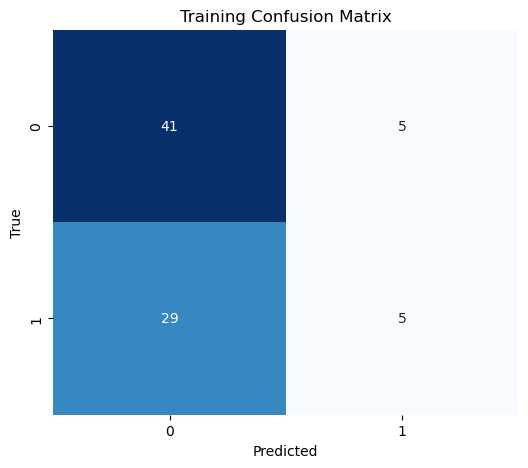

Test Confusion Matrix for Logistic Regression:


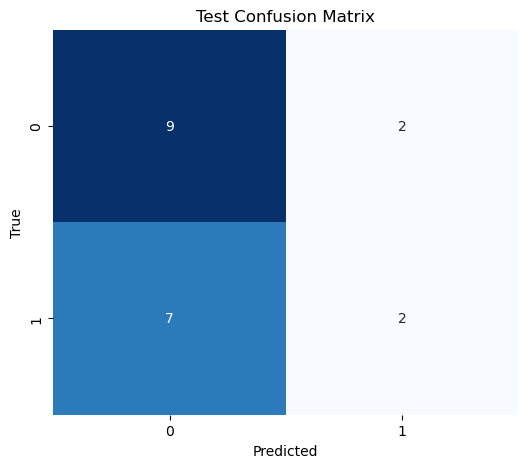

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Example synthetic data (replace with your actual dataset)
# Example: 100 samples, 5 features, binary classification labels
x = np.random.rand(100, 5)  # 100 samples, 5 features
y = np.random.randint(0, 2, 100)  # Binary classification (0 or 1)

# Ensure x and y have consistent lengths
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Ensure that x_train and y_train have the same length
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Initialize the LabelEncoder
le = LabelEncoder()

# Ensure target variable is properly encoded
y_train = le.fit_transform(y_train)  # Encode labels in y_train
y_test = le.transform(y_test)        # Apply the same encoding to y_test

# Logistic Regression model
lr = LogisticRegression(max_iter=1000)  # Increase iterations if needed
lr.fit(x_train, y_train)

# Evaluate the model
def evaluate_classification(model, model_name, x_train, x_test, y_train, y_test):
    print(f"Evaluating {model_name}...")
    
    # Predictions on training and test data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Evaluate performance
    print(f"Training Classification Report for {model_name}:")
    print(classification_report(y_train, y_train_pred))
    
    print(f"Test Classification Report for {model_name}:")
    print(classification_report(y_test, y_test_pred))
    
    print(f"Training Confusion Matrix for {model_name}:")
    plot_confusion_matrix(y_train, y_train_pred, "Training Confusion Matrix")
    
    print(f"Test Confusion Matrix for {model_name}:")
    plot_confusion_matrix(y_test, y_test_pred, "Test Confusion Matrix")
    
    # Optionally, you can add additional plots here for performance, anomalies, etc.

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Now call the evaluation function
evaluate_classification(lr, "Logistic Regression", x_train, x_test, y_train, y_test)


In [14]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)
evaluate_classification(knn, "KNeighbors Classifier", x_train, x_test, y_train, y_test)

Evaluating KNeighbors Classifier...
Training Classification Report for KNeighbors Classifier:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     34515
           1       0.99      0.99      0.99     29982

    accuracy                           0.99     64497
   macro avg       0.99      0.99      0.99     64497
weighted avg       0.99      0.99      0.99     64497

Test Classification Report for KNeighbors Classifier:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8578
           1       0.99      0.99      0.99      7547

    accuracy                           0.99     16125
   macro avg       0.99      0.99      0.99     16125
weighted avg       0.99      0.99      0.99     16125

Training Confusion Matrix for KNeighbors Classifier:
[[34243   272]
 [  428 29554]]
Test Confusion Matrix for KNeighbors Classifier:
[[8509   69]
 [ 108 7439]]


In [15]:
 #Gaussian Naive Bayes
gnb = GaussianNB().fit(x_train, y_train)
evaluate_classification(gnb, "Gaussian Naive Bayes", x_train, x_test, y_train, y_test)

Evaluating Gaussian Naive Bayes...
Training Classification Report for Gaussian Naive Bayes:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     34515
           1       0.94      0.90      0.92     29982

    accuracy                           0.93     64497
   macro avg       0.93      0.93      0.93     64497
weighted avg       0.93      0.93      0.93     64497

Test Classification Report for Gaussian Naive Bayes:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      8578
           1       0.94      0.91      0.93      7547

    accuracy                           0.93     16125
   macro avg       0.93      0.93      0.93     16125
weighted avg       0.93      0.93      0.93     16125

Training Confusion Matrix for Gaussian Naive Bayes:
[[32869  1646]
 [ 2854 27128]]
Test Confusion Matrix for Gaussian Naive Bayes:
[[8159  419]
 [ 666 6881]]


In [16]:
# Linear Support Vector Classifier
lin_svc = svm.LinearSVC().fit(x_train, y_train)
evaluate_classification(lin_svc, "Linear SVC", x_train, x_test, y_train, y_test)

Evaluating Linear SVC...
Training Classification Report for Linear SVC:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     34515
           1       0.99      0.95      0.97     29982

    accuracy                           0.97     64497
   macro avg       0.97      0.97      0.97     64497
weighted avg       0.97      0.97      0.97     64497

Test Classification Report for Linear SVC:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      8578
           1       0.99      0.95      0.97      7547

    accuracy                           0.97     16125
   macro avg       0.97      0.97      0.97     16125
weighted avg       0.97      0.97      0.97     16125

Training Confusion Matrix for Linear SVC:
[[34118   397]
 [ 1557 28425]]
Test Confusion Matrix for Linear SVC:
[[8482   96]
 [ 383 7164]]


In [17]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(max_depth=3).fit(x_train, y_train)
tdt = DecisionTreeClassifier().fit(x_train, y_train)
evaluate_classification(tdt, "Decision Tree Classifier", x_train, x_test, y_train, y_test)

Evaluating Decision Tree Classifier...
Training Classification Report for Decision Tree Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34515
           1       1.00      1.00      1.00     29982

    accuracy                           1.00     64497
   macro avg       1.00      1.00      1.00     64497
weighted avg       1.00      1.00      1.00     64497

Test Classification Report for Decision Tree Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8578
           1       1.00      1.00      1.00      7547

    accuracy                           1.00     16125
   macro avg       1.00      1.00      1.00     16125
weighted avg       1.00      1.00      1.00     16125

Training Confusion Matrix for Decision Tree Classifier:
[[34515     0]
 [    1 29981]]
Test Confusion Matrix for Decision Tree Classifier:
[[8560   18]
 [  28 7519]]


In [18]:
# Random Forest Classifier
rf = RandomForestClassifier().fit(x_train, y_train)
evaluate_classification(rf, "Random Forest Classifier", x_train, x_test, y_train, y_test)

Evaluating Random Forest Classifier...
Training Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34515
           1       1.00      1.00      1.00     29982

    accuracy                           1.00     64497
   macro avg       1.00      1.00      1.00     64497
weighted avg       1.00      1.00      1.00     64497

Test Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8578
           1       1.00      1.00      1.00      7547

    accuracy                           1.00     16125
   macro avg       1.00      1.00      1.00     16125
weighted avg       1.00      1.00      1.00     16125

Training Confusion Matrix for Random Forest Classifier:
[[34514     1]
 [    0 29982]]
Test Confusion Matrix for Random Forest Classifier:
[[8572    6]
 [  16 7531]]


In [19]:
# XGBoost Regressor (for Regression Task)
xg_r = xgb.XGBRegressor(objective ='reg:linear', n_estimators=20).fit(x_train, y_train)
train_error = metrics.mean_squared_error(y_train, xg_r.predict(x_train), squared=False)
test_error = metrics.mean_squared_error(y_test, xg_r.predict(x_test), squared=False)
print(f"Training Error (XGBoost): {train_error}  Test Error (XGBoost): {test_error}")

Training Error (XGBoost): 0.037001454112249976  Test Error (XGBoost): 0.051564495831481996


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the datasets
data_train = pd.read_csv("/Users/sharathkarnati/Desktop/ml_codes/KDDTrain+.txt", header=None)
data_test = pd.read_csv("/Users/sharathkarnati/Desktop/ml_codes/KDDTest+.txt", header=None)
# Check the number of columns in both training and testing datasets
print(f"Number of columns in training data: {data_train.shape[1]}")
print(f"Number of columns in testing data: {data_test.shape[1]}")

column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", 
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", 
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", 
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", 
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
    "dst_host_srv_rerror_rate", "extra_column", "class"
]


# Assign column names to the datasets
data_train.columns = column_names
data_test.columns = column_names

# Combine train and test data to ensure consistent dummy variable columns
data_combined = pd.concat([data_train, data_test], axis=0)

# Define 'X' as the feature matrix and 'y' as the target variable
X_combined = data_combined.drop(columns=['class'])
y_combined = data_combined['class']

# Convert categorical features into numeric values using pd.get_dummies
X_combined = pd.get_dummies(X_combined)

# Split the combined data back into train and test sets
X_train = X_combined.iloc[:len(data_train), :]
X_test = X_combined.iloc[len(data_train):, :]
y_train = y_combined.iloc[:len(data_train)]
y_test = y_combined.iloc[len(data_train):]

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Adjust the number of components to your needs
X_train_reduced = pca.fit_transform(X_train)  # Fit and transform on the training data
X_test_reduced = pca.transform(X_test)  # Only transform on the test data

# Train Random Forest Classifier with the reduced training data
rrf = RandomForestClassifier(n_estimators=100, random_state=42)
rrf.fit(X_train_reduced, y_train)

# Evaluate the model
def evaluate_classification(model, model_name, X_train, X_test, y_train, y_test):
    # Predict on the training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Print classification report for both train and test sets
    print(f"Classification Report for {model_name} (Training Data):\n")
    print(classification_report(y_train, y_train_pred))
    
    print(f"Classification Report for {model_name} (Test Data):\n")
    print(classification_report(y_test, y_test_pred))

    # Print confusion matrix for test data
    print(f"Confusion Matrix for {model_name} (Test Data):\n")
    print(confusion_matrix(y_test, y_test_pred))

# Call the evaluation function
evaluate_classification(rrf, "Random Forest with PCA", X_train_reduced, X_test_reduced, y_train, y_test)


Number of columns in training data: 43
Number of columns in testing data: 43
Classification Report for Random Forest with PCA (Training Data):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        62
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        65
           4       1.00      1.00      1.00        79
           5       1.00      1.00      1.00        81
           6       1.00      1.00      1.00        96
           7       1.00      1.00      1.00       118
           8       1.00      1.00      1.00       106
           9       1.00      1.00      1.00       194
          10       1.00      1.00      1.00       253
          11       1.00      1.00      1.00       641
          12       1.00      1.00      1.00       729
          13       1.00      1.00      1.00       451
          14       1.00      1.00      1.00  

In [28]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

# Load the datasets
data_train = pd.read_csv("/Users/sharathkarnati/Desktop/ml_codes/KDDTrain+.txt", header=None)
data_test = pd.read_csv("/Users/sharathkarnati/Desktop/ml_codes/KDDTest+.txt", header=None)

# Check the number of columns in each dataset
print(f"Number of columns in data_train: {data_train.shape[1]}")
print(f"Number of columns in data_test: {data_test.shape[1]}")

# Define the column names based on the dataset description
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", 
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", 
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", 
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", 
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
    "dst_host_srv_rerror_rate", "class"
]

# If the datasets have an extra column (like an index column), remove it
data_train = data_train.iloc[:, 1:]  # Remove the first column if it's an index
data_test = data_test.iloc[:, 1:]  # Remove the first column if it's an index

# Assign column names to the datasets
data_train.columns = column_names
data_test.columns = column_names

# Define 'X' as the feature matrix and 'y' as the target variable
X_train = data_train.drop(columns=['class'])
y_train = data_train['class']

X_test = data_test.drop(columns=['class'])
y_test = data_test['class']

# Convert categorical features into numeric values (e.g., protocol_type, service, flag)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Ensure the feature matrices have the same shape by aligning the columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Neural Network Model (Deep Learning)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1],), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=512, epochs=100, verbose=2)

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print results
print(f"Training Accuracy (Neural Network): {train_acc*100}%  Test Accuracy (Neural Network): {test_acc*100}%")


Number of columns in data_train: 43
Number of columns in data_test: 43
Epoch 1/100
247/247 - 1s - 5ms/step - accuracy: 4.6835e-04 - loss: 65223778304.0000
Epoch 2/100
247/247 - 1s - 4ms/step - accuracy: 4.8423e-04 - loss: 38363193344.0000
Epoch 3/100
247/247 - 1s - 3ms/step - accuracy: 5.0011e-04 - loss: 26514864128.0000
Epoch 4/100
247/247 - 1s - 3ms/step - accuracy: 4.7629e-04 - loss: 21062860800.0000
Epoch 5/100
247/247 - 1s - 4ms/step - accuracy: 4.8423e-04 - loss: 12999608320.0000
Epoch 6/100
247/247 - 1s - 4ms/step - accuracy: 4.8423e-04 - loss: 9583443968.0000
Epoch 7/100
247/247 - 1s - 4ms/step - accuracy: 4.9217e-04 - loss: 6315628032.0000
Epoch 8/100
247/247 - 1s - 3ms/step - accuracy: 4.9217e-04 - loss: 4233739264.0000
Epoch 9/100
247/247 - 1s - 3ms/step - accuracy: 4.8423e-04 - loss: 2849927168.0000
Epoch 10/100
247/247 - 1s - 4ms/step - accuracy: 4.8423e-04 - loss: 1951836160.0000
Epoch 11/100
247/247 - 1s - 3ms/step - accuracy: 4.9217e-04 - loss: 1152221312.0000
Epoch 12/